# 省级年鉴数据探索

In [20]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np
import seaborn as sns
import os

plt.style.use("fivethirtyeight")
merged = pd.read_csv(r"../data/province_merged.csv")
watersheds = pd.read_csv(r"../data/watershed_merged.csv")

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 用来cell内显示matplotlib图
%matplotlib inline

## 2. 探索地下水占比

问题：地下水的开采在多年间发生了怎样的变化？

### 2.1 全流域平均

In [12]:
SUB_USE_TYPE = ['农田灌溉', '林牧渔畜', '工业', '城镇公共', '居民生活', '生态环境']
# 将整合的数据提取某项目进行分析
def get_type_data(d, p):
    return d.groupby("项目").get_group(p)

# 绘制地下水占比多年变化图
def plot_ratio_surface_groundwater(data, sector, ax, province='Mean of all province'):
    d = data.copy()
    
    # 计算所需部门的地下水占比
    def calculate_ratio(sector):
        sur = sector + "_surface"
        gro = sector + "_groundwater"
        d[sector+'_sum'] = d[sur] + d[gro]
        d[sector+'_ratio'] = d[gro] / d[sector+'_sum']
    
    # 如果要展示所有sector：
    if sector == "All":
        ratio_list = []
        for sec in SUB_USE_TYPE:
            calculate_ratio(sec)
            ratio_list.append(sec+"_ratio")
        
        if province == 'Mean of all province':
            grouped = d.groupby("年份").mean()
            grouped[ratio_list].plot(ax=ax)
        else:
            pro = d.groupby("省份").get_group(province)
            pro.plot(x="年份", y=ratio_list, ax=ax)
        ax.set_title(province)
        
    
    elif type(sector) is list:
        for sec in sector:
            calculate_ratio(sec)
            ratio_list.append(sec+"_ratio")
        
        if province == 'Mean of all province':
            grouped = d.groupby("年份").mean()
            grouped[sector].plot(ax=ax)
        else:
            pro = d.groupby("省份").get_group(province)
            pro.plot(x="年份", y=sector, ax=ax)
            
            
    # 如果只需要展示某sector：
    else:
        calculate_ratio(sector)
        if province == 'Mean of all province':
            d.groupby("年份")[sector+'_ratio'].mean().plot(x="年份", ax=ax)
        else:
            pro = d.groupby("省份").get_group(province)
            pro.plot(x="年份", y=sector+'_ratio', ax=ax)
            ax.set_title(province+", "+sector)
        ax.set_title(province + ", " + sector)
    
    ax.set_ylabel("Proportion of groundwater")
    ax.set_xlabel("")
    ax.set_xlim(2002, 2018)
    

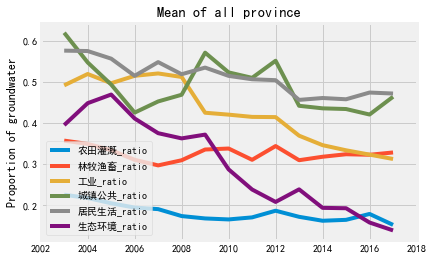

In [13]:
fig, ax = plt.subplots()
plot_ratio_surface_groundwater(get_type_data(merged, p="取水量"), sector="All", ax=ax)
plt.show();

### 2.2 分省，所有部门

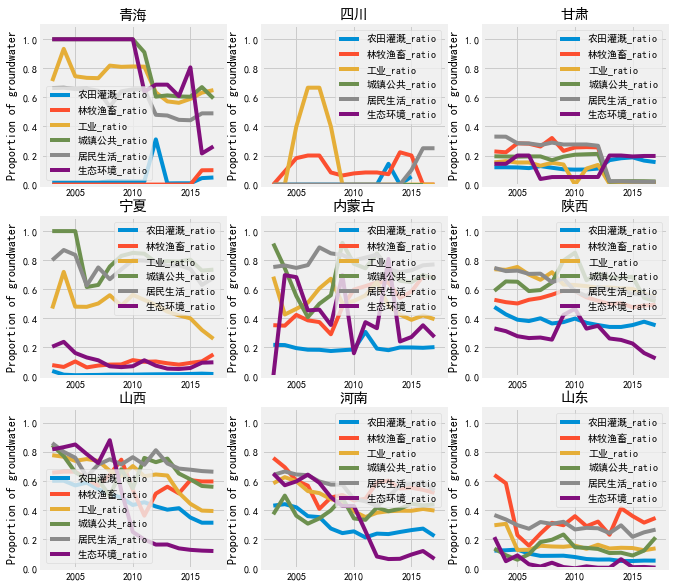

In [16]:
sys.path.append("..")
from tools.processing import add_subplot_by_order

gs = GridSpec(3, 3)
fig = plt.figure(figsize=(10, 10))

province_list = list(merged['省份'].unique())
province_list.remove("合计")

for i in range(len(province_list)):
    province = province_list[i]
    ax = fig.add_subplot(gs[add_subplot_by_order(gs=(3, 3), order=i+1)])
    plot_ratio_surface_groundwater(get_type_data(merged, p="取水量"), sector="All", ax=ax, province=province)
    ax.set_ylim(0, 1.1)
plt.show();

### 2.3 总结

#### 根据上述结果，对地下水取用的基本形势有如下判断：

- 地下水在取水量中占比总体呈现下降趋势
- 对于河源地区的青海、四川、甘肃，对地下水的依赖很有限
- 城镇公共、居民生活、工业等，没在上游地区（宁夏、内蒙）属于地下水的高依赖地区，但农田灌溉主要依赖地表水
- 在陕西、陕西和河南，农业对地下水的依赖相对偏高
- 城镇公共、居民生活、生态环境，相对属于比较依赖地下水的部门
- 生态环境的地下水取用量普遍在近7年内呈现明显下降趋势

#### 相应的也带来了新的疑问：

- 为什么地下水取用量总体呈下降趋势，而且越是下游下降趋势越显著，但地下水存量越来越少，且越是下游减少越明显？
    - 根据我的猜测，下游的渠道护砌率是最高的，影响了地下水补给，导致地下水存量下降。
    - 地下水漏斗的形成，可能已经改变了下游的地下含水层流动方向。
    
- 整体来看，源头、上游、中游、下游的地表-地下水取用模式还是存在明显差异的。
    - 这些模式的差异，是否来自于长期分工的结果？
    - 这种模式的出现，是对自然资源分配的很好的适应，还是人地系统错配的表现？

## 3. 分区统计

接下来考虑对各分区的情况进行统计

In [21]:
SR = ['龙羊峡以上', '龙羊峡至兰州', '河源-兰州']
UR = ['兰州至头道拐', '兰州-头道拐']
MR = ['头道拐至龙门', '龙门至三门峡', '三门峡至花园口', '头道拐-龙门', '龙门-三门峡', '三门峡-花园口']
DR = ['花园口以下', '花园口-利津', '利津-河口']
WATERSHED_TO_SUBREGION = {
    "SR": SR,
    "UR": UR,
    "MR": MR,
    "DR": DR
}

def judge_region(x):
    for k, v in WATERSHED_TO_SUBREGION.items():
        if x in v:
            return k

        
watersheds['region'] = watersheds['分区'].apply(judge_region)
watersheds = watersheds[watersheds['region'].notna()]
withdraw = get_type_data(watersheds, "取水量")

### 3.1 先看看不同区域的总取水量

In [50]:
def plot_volumn_sector(sector, ax):
    d = withdraw.copy()
    d[sector+"_sum"] = d[sector+"_groundwater"] + d[sector+"_surface"]
    sns.lineplot(x="年份", y=sector+"_sum", hue="region", data=d, ax=ax)

def plot_ratio_regions(data, ax, region="All"):
    d = data.copy()
    
    # 计算所需部门的地下水占比
    def calculate_ratio(data, sector):
        sur = sector + "_surface"
        gro = sector + "_groundwater"
        data[sector+'_sum'] = data[sur] + data[gro]
        data[sector+'_ratio'] = data[gro] / data[sector+'_sum']
    
    # 如果要展示所有子区域的对比：
    if region == "All":
        calculate_ratio(d, "合计")
        sns.lineplot(x="年份", y="合计_ratio", hue="region", data=d, ax=ax)
        ax.set_ylim(0, 1.1)
        output = {}
        for region in regions:
            output[region] = d[d['region'] == region]['合计_ratio']
        output = pd.DataFrame(output)
    
    # 如果要展示某个子区域的所有部门对比（源头？上游？中游？下游？）
    else:
        subset = d.groupby("region").get_group(region)
        agg = subset.groupby("年份").sum()
        regions_ratio = []
        
        for sec in SUB_USE_TYPE:
            calculate_ratio(agg, sec)
            regions_ratio.append(sec+"_ratio")
        
        output = agg[regions_ratio].plot(ax=ax, legend=True)
        ax.set_ylim(0, 1.1)
    ax.set_xlim(2003, 2017)
    ax.set_title(region)
    ax.set_xlabel("")
    return output

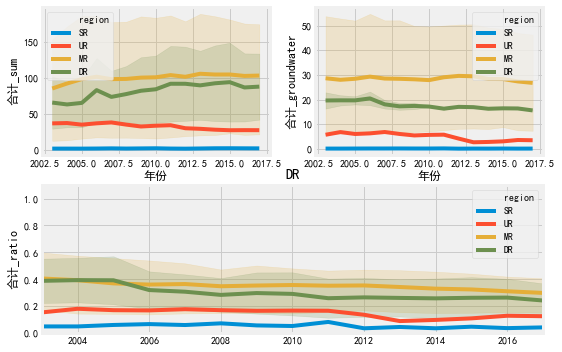

In [51]:
gs = GridSpec(2, 2)
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

plot_volumn_sector("合计", ax1)
sns.lineplot(x="年份", y="合计"+"_groundwater", hue="region", data=withdraw, ax=ax2)
output = plot_ratio_regions(data=withdraw, ax=ax3, region="All")
plt.show();

In [57]:
def calculate_ratio(data, sector):
    sur = sector + "_surface"
    gro = sector + "_groundwater"
    data[sector+'_sum'] = data[sur] + data[gro]
    data[sector+'_ratio'] = data[gro] / data[sector+'_sum']
    return data

calculate_ratio(withdraw, '合计').groupby(['region', '年份']).mean()['合计_ratio']

region  年份  
DR      2003    0.389190
        2004    0.394571
        2005    0.393403
        2006    0.320791
        2007    0.308549
        2008    0.284966
        2009    0.298660
        2010    0.292432
        2011    0.260390
        2012    0.266527
        2013    0.262575
        2014    0.259347
        2015    0.263585
        2016    0.264977
        2017    0.243394
MR      2003    0.406711
        2004    0.393840
        2005    0.370320
        2006    0.361591
        2007    0.365439
        2008    0.349202
        2009    0.354525
        2010    0.358231
        2011    0.353122
        2012    0.355118
        2013    0.343496
        2014    0.331311
        2015    0.325466
        2016    0.311902
        2017    0.299667
SR      2003    0.051020
        2004    0.051020
        2005    0.061856
        2006    0.068293
        2007    0.061404
        2008    0.073892
        2009    0.058559
        2010    0.054167
        2011    0.084158
        2012

整体来说，河源和中游的总取水量保持稳定，中游取水最多，下游取水量有上升趋势，上游取水量有下降趋势。

而对地下水而言，取水量均呈下降趋势

### 3.2 不同区域，各部门的地下水占比情况

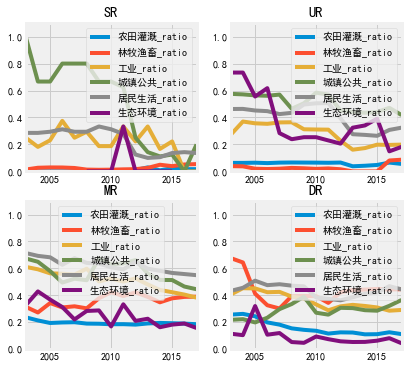

In [24]:
gs = GridSpec(2, 2)
fig = plt.figure(figsize=(6, 6))
regions = ['SR', 'UR', 'MR', 'DR']
for i in range(len(regions)):
    region = regions[i]
    ax = fig.add_subplot(gs[add_subplot_by_order(gs=(2, 2), order=i+1)])
    plot_ratio_regions(data=withdraw, ax=ax, region=region)
plt.show();

### 3.3 对四个区域的基本情况刻画：

- 河源区（SR）：保持较低的引水量，且引地下水比例下降明显。
    - 功能一直比较明确，就是保证水源涵养功能
    - 转向地下水，可以适当开发，因为水储量变化趋势向好


- 上游区（UR）：引水量第二低，引水途径以地表水为主，总引水量在下降，地下水量也在下降，地下水占比保持恒定。
    - 功能集约灌溉，粮食生产，转向工业。


- 中游区（MR）：引水量、地下水引水量最多，地下水引水量占比最大，地下水引水量相对恒定，总引水量上升趋势。
    - 引水控制，生态恢复


- 下游区（DR）：总引水量显著增加，但地下水引水量占比下降趋势。
    - 农业集约，科技进步，农业功能削弱
    - 城镇人居功能加强

### 3.3 对四个区域的基本情况刻画：

- 河源区（SR）：保持较低的引水量，且引地下水比例下降明显。
    - 功能一直比较明确，就是保证水源涵养功能
    - 转向地下水，可以适当开发，因为水储量变化趋势向好


- 上游区（UR）：引水量第二低，引水途径以地表水为主，总引水量在下降，地下水量也在下降，地下水占比保持恒定。
    - 功能集约灌溉，粮食生产，转向工业。


- 中游区（MR）：引水量、地下水引水量最多，地下水引水量占比最大，地下水引水量相对恒定，总引水量上升趋势。
    - 引水控制，生态恢复


- 下游区（DR）：总引水量显著增加，但地下水引水量占比下降趋势。
    - 农业集约，科技进步，农业功能削弱
    - 城镇人居功能加强